# 1D parameter estimation using MCMC: kernel multplication

This example will cover:

 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions


In [1]:
from gptide import cov
from gptide import GPtideScipy
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats
from gptide import stats as gpstats

## Generate some data

In [2]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0
η_m = 4
ℓ_m = 150


covfunc = cov.matern32_1d

###
# Domain size parameters
dx = 25.
N = 200
covparams = (η_m, ℓ_m)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)


Text(0.5, 1.0, 'Noise-free Matern 1/2')

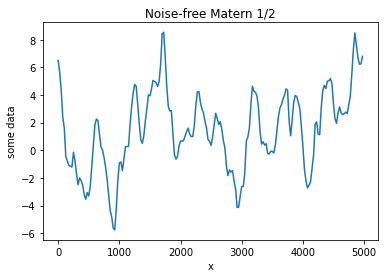

In [3]:
plt.figure()
plt.plot(xd, yd)
plt.ylabel('some data')
plt.xlabel('x')
plt.title('Noise-free Matern 1/2')

In [4]:
np.random.seed(1)
noise = 0

ℓ_p = 60
η_p = 8

covfunc = cov.cosine_1d

covparams = (η_p, ℓ_p)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)

def sm(x, xpr, params):
    
    η_m, ℓ_m, x_p, ℓ_p = params
    
    return cov.matern32_1d(x, xpr, (η_m, ℓ_m)) * cov.cosine(x, xpr, (x_p, ℓ_p))

Text(0.5, 1.0, 'Noise-free cosine')

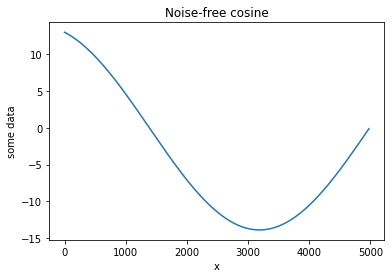

In [5]:
plt.figure()
plt.plot(xd, yd)
plt.ylabel('some data')
plt.xlabel('x')
plt.title('Noise-free cosine')

In [6]:
np.random.seed(1)
noise = 0.5

def sm(x, xpr, params):
        
    η_m, ℓ_m, η_p, ℓ_p = params

    
    return cov.matern32_1d(x, xpr, (η_m, ℓ_m)) * cov.cosine_1d(x, xpr, (η_p, ℓ_p))

covfunc = sm

covparams = (η_m, ℓ_m, η_p, ℓ_p)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)


Text(0.5, 1.0, 'Noisy combined kernel')

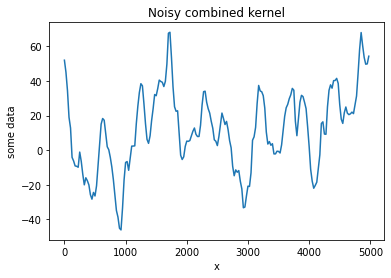

In [7]:
plt.figure()
plt.plot(xd, yd)
plt.ylabel('some data')
plt.xlabel('x')
plt.title('Noisy combined kernel')

## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [8]:
from gptide import mcmc
n = len(xd)


In [11]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(0.4, 0.25, 1e-15, 1e2)         # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(1, 1, 1e-15, 1e2),              # η_m - true value 4
                    gpstats.truncnorm(125, 50, 1e-15, 1e4),           # ℓ_m - true value 150
                    gpstats.truncnorm(2, 2, 1e-15, 1e4),              # η_p - true value 8
                    gpstats.truncnorm(50, 10, 1e-15, 1e4)             # ℓ_p - true value 60
                   ]

samples, log_prob, priors_out, sampler = mcmc.mcmc( xd, 
                                                    yd, 
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=100,
                                                    niter=50,
                                                    verbose=False)



Running burn-in...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


## Find sample with highest log prob

In [12]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η_m (true):   {:3.2f},  η_m   (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_m (true):   {:3.2f},  ℓ_m   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('η_p (true):   {:3.2f},  η_p   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3]))
print('ℓ_p (true):   {:3.2f},  ℓ_p   (mcmc): {:3.2f}'.format(covparams[3],  MAP[4])) 


Noise (true): 0.50,  Noise (mcmc): 0.77
η_m (true):   4.00,  η_m   (mcmc): 3.28
ℓ_m (true):   150.00,  ℓ_m   (mcmc): 142.82
η_p (true):   8.00,  η_p   (mcmc): 7.81
ℓ_p (true):   60.00,  ℓ_p   (mcmc): 48.30


## Posterior density plot

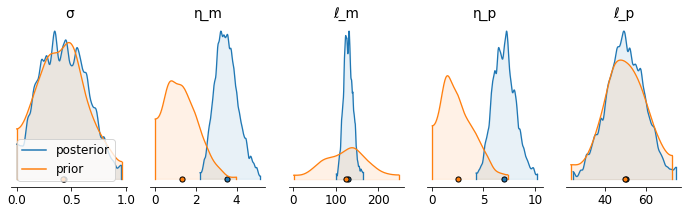

In [13]:
labels = ['σ','η_m','ℓ_m','η_p','ℓ_p']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)


## Posterior corner plot

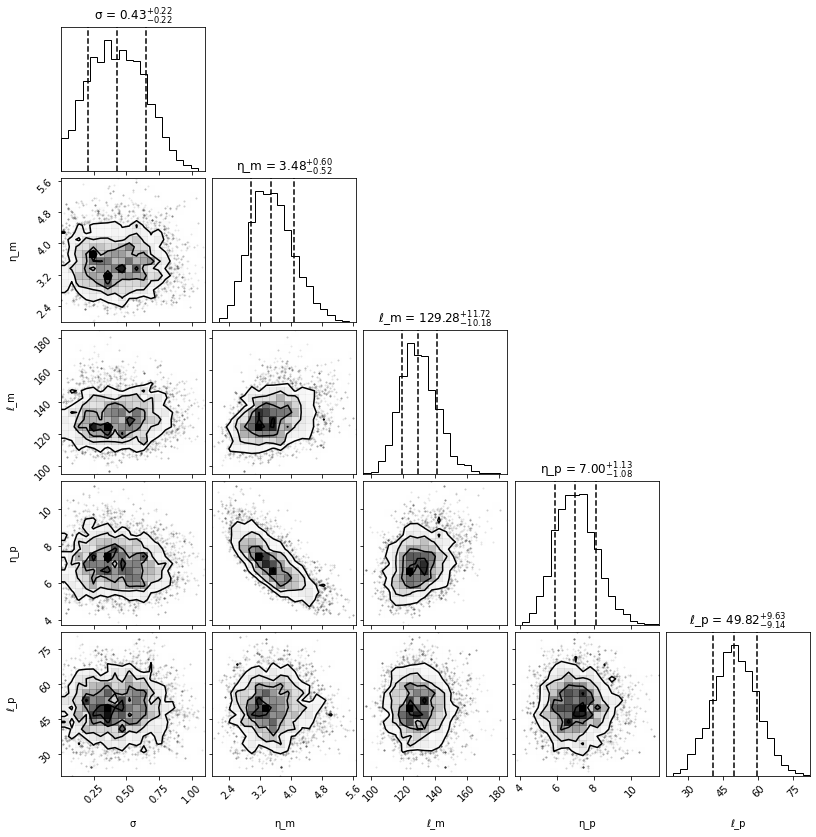

In [14]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

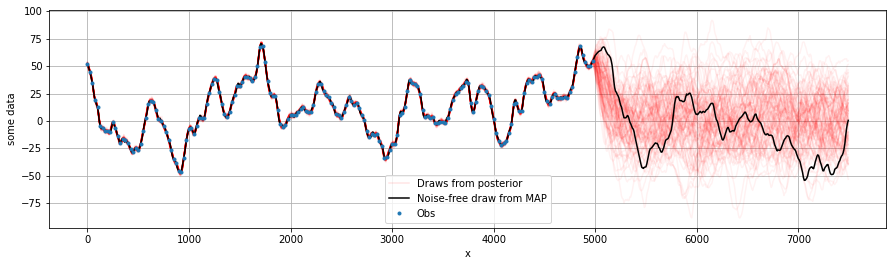

In [15]:
plt.figure(figsize=(15, 4))
plt.ylabel('some data')
plt.xlabel('x')

xo = np.arange(0,dx*N*1.5,dx/3)[:,None]

for i, draw in enumerate(np.random.uniform(0, samples.shape[0], 100).astype(int)):
    sample = samples[draw, :]
    OI = GPtideScipy(xd, xo, sample[0], covfunc, sample[1:], 
             P=1, mean_func=None)
    out_samp = OI.conditional(yd)
    plt.plot(xo, out_samp, 'r', alpha=0.05, label=None)
    
plt.plot(xo, out_samp, 'r', alpha=0.1, label='Draws from posterior') # Just for legend
    
OI = GPtideScipy(xd, xo, 0, covfunc, MAP[1:], 
             P=1, mean_func=None)
out_map = OI.conditional(yd)

plt.plot(xo, out_map, 'k', label='Noise-free draw from MAP')
plt.plot(xd, yd,'.', label='Obs')
plt.legend()
plt.grid()
